In [1]:
import os 
import sys

current_file_dir = os.getcwd()

root_dir = os.path.dirname(current_file_dir)

sys.path.append(root_dir)
dataset_dir = os.path.join(root_dir, 'data')


In [2]:
%matplotlib inline

from nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot=dataset_dir + "/sets/nuscenes", verbose=True)


Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.607 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
nusc.list_lidarseg_categories(sort_by='count')


Calculating semantic point stats for nuScenes-lidarseg...
  1  animal                                   nbr_points=           0
  7  human.pedestrian.stroller                nbr_points=           0
  8  human.pedestrian.wheelchair              nbr_points=           0
 19  vehicle.emergency.ambulance              nbr_points=           0
 20  vehicle.emergency.police                 nbr_points=           0
 10  movable_object.debris                    nbr_points=          48
  6  human.pedestrian.police_officer          nbr_points=          64
  3  human.pedestrian.child                   nbr_points=         230
  4  human.pedestrian.construction_worker     nbr_points=       1,412
 14  vehicle.bicycle                          nbr_points=       1,463
 11  movable_object.pushable_pullable         nbr_points=       2,293
  5  human.pedestrian.personal_mobility       nbr_points=       4,096
 13  static_object.bicycle_rack               nbr_points=       4,476
 12  movable_object.trafficcone 

In [4]:
nusc.list_lidarseg_categories(sort_by='count')


Calculating semantic point stats for nuScenes-lidarseg...
  1  animal                                   nbr_points=           0
  7  human.pedestrian.stroller                nbr_points=           0
  8  human.pedestrian.wheelchair              nbr_points=           0
 19  vehicle.emergency.ambulance              nbr_points=           0
 20  vehicle.emergency.police                 nbr_points=           0
 10  movable_object.debris                    nbr_points=          48
  6  human.pedestrian.police_officer          nbr_points=          64
  3  human.pedestrian.child                   nbr_points=         230
  4  human.pedestrian.construction_worker     nbr_points=       1,412
 14  vehicle.bicycle                          nbr_points=       1,463
 11  movable_object.pushable_pullable         nbr_points=       2,293
  5  human.pedestrian.personal_mobility       nbr_points=       4,096
 13  static_object.bicycle_rack               nbr_points=       4,476
 12  movable_object.trafficcone 

In [5]:
nusc.list_lidarseg_categories(sort_by='count', gt_from='lidarseg')


Calculating semantic point stats for nuScenes-lidarseg...
  1  animal                                   nbr_points=           0
  7  human.pedestrian.stroller                nbr_points=           0
  8  human.pedestrian.wheelchair              nbr_points=           0
 19  vehicle.emergency.ambulance              nbr_points=           0
 20  vehicle.emergency.police                 nbr_points=           0
 10  movable_object.debris                    nbr_points=          48
  6  human.pedestrian.police_officer          nbr_points=          64
  3  human.pedestrian.child                   nbr_points=         230
  4  human.pedestrian.construction_worker     nbr_points=       1,412
 14  vehicle.bicycle                          nbr_points=       1,463
 11  movable_object.pushable_pullable         nbr_points=       2,293
  5  human.pedestrian.personal_mobility       nbr_points=       4,096
 13  static_object.bicycle_rack               nbr_points=       4,476
 12  movable_object.trafficcone 

In [80]:
## filter by category 24
filtered_lidarseg_labels = [24]

# In [7]:
my_sample = nusc.sample[58]

# In [10]:
sample_data_token = my_sample['data']['LIDAR_TOP']
sample_token = my_sample['token']


In [81]:
pointsensor_token = my_sample['data']['LIDAR_TOP']
camera_token = my_sample['data']['CAM_FRONT'] # Ön kamerayı kullanalım

In [82]:
points, coloring, camera_image_pil = nusc.explorer.map_pointcloud_to_image(
        pointsensor_token=pointsensor_token,
        camera_token=camera_token,
        filter_lidarseg_labels=filtered_lidarseg_labels,
        render_intensity=False,
        show_panoptic=False,
        show_lidarseg=True)

    

In [ ]:
import numpy as np
from PIL import Image, ImageDraw



def check_coloring_shape(coloring):
    if coloring.ndim != 2:
        raise ValueError("Coloring array must be 2D.")

    if coloring.shape[1] not in [1, 3, 4]:
        raise ValueError("Coloring array must have 1, 3, or 4 channels.")

    if coloring.shape[1] == 4:
        color = tuple((coloring[0, :3] * 255).astype(int))
    elif coloring.shape[1] == 3:
        color = tuple((coloring[0, :] * 255).astype(int))
    elif coloring.shape[1] == 1:
        gray_value = int(coloring[0, 0] * 255)
        color = (gray_value, gray_value, gray_value)
    else:
        raise ValueError("Coloring array must have 1, 3, or 4 channels.")
    return color

def create_pointcloud_image(points, coloring, image_size, dot_size=1):
    result_image = Image.new('RGB', image_size, (0, 0, 0))
    draw = ImageDraw.Draw(result_image)
    
    x_coords = points[0, :]
    y_coords = points[1, :]
    
    for i in range(len(x_coords)):
        x, y = int(x_coords[i]), int(y_coords[i])
        
        if 0 <= x < image_size[0] and 0 <= y < image_size[1]:
            try:
                color = check_coloring_shape(coloring[i])
            except ValueError as e:
                print(f"Error processing color for point {i}: {e}")
                continue

            if color == (255, 255, 255):  # Ignore white points
                continue
            if dot_size <= 1:
                draw.point((x, y), fill=color)
            else:
                radius = dot_size // 2
                draw.ellipse([x-radius, y-radius, x+radius, y+radius], fill=color)
    
    return result_image

def create_morphological_polygon(points, coloring, image_size=(512, 512), dot_size=1, ignore_white=True):
    valid_points = []
    for i in range(len(points[0])):
        x, y = int(points[0, i]), int(points[1, i])
        if 0 <= x < image_size[0] and 0 <= y < image_size[1]:
            try:
                color = check_coloring_shape(coloring[i])
            except ValueError as e:
                print(f"Error processing color for point {i}: {e}")
                continue
            if ignore_white and color == (255, 255, 255):
                continue
            valid_points.append([x, y])
    
    if len(valid_points) < 3:
        return Image.new('L', image_size, 0)
    
    point_mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(point_mask)
    
    for point in valid_points:
        x, y = int(point[0]), int(point[1])
        draw.ellipse([x-2, y-2, x+2, y+2], fill=255)
    
    mask_array = np.array(point_mask)
    
    from scipy.ndimage import binary_dilation, binary_fill_holes
    
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    se = x*x + y*y <= radius*radius
    
    dilated = binary_dilation(mask_array, structure=se)
    
    filled = binary_fill_holes(dilated)
    
    result_mask = filled.astype(np.uint8) * 255
    
    return Image.fromarray(result_mask)




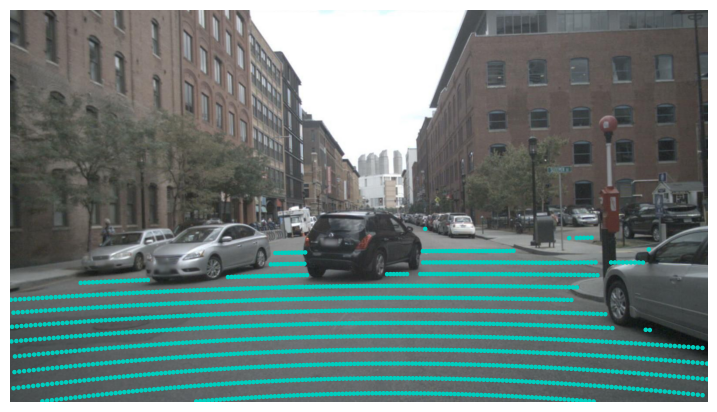

In [83]:
nusc.render_pointcloud_in_image(sample_token=sample_token,
                                pointsensor_channel='LIDAR_TOP',
                                camera_channel='CAM_FRONT',
                                filter_lidarseg_labels=filtered_lidarseg_labels,
                                render_intensity=False,
                                show_lidarseg=True,
                                show_panoptic=False,
                                show_lidarseg_legend=False)

In [84]:
points.shape, coloring.shape, camera_image_pil.size

((3, 2947), (2947, 4), (1600, 900))

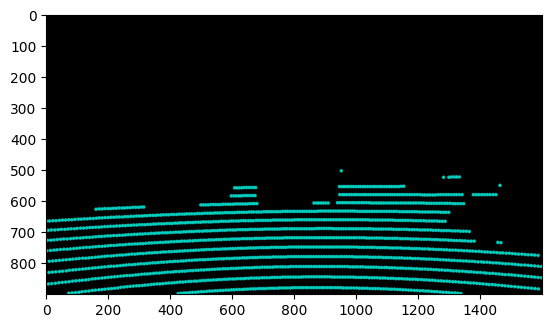

In [ ]:
import numpy as np
from PIL import Image, ImageDraw



def preprocess_coloring(coloring):
    coloring = np.array(coloring)

    if coloring.ndim == 1:
        # Eğer tek kanal ise → gri tona çevir
        if coloring.shape[0] == 1:
            gray = int(coloring[0] * 255)
            return (gray, gray, gray)
        elif coloring.shape[0] == 3 or coloring.shape[0] == 4:
            return tuple((coloring[:3] * 255).astype(int))
        else:
            raise ValueError(f"Unsupported 1D coloring shape: {coloring.shape}")
    elif coloring.ndim == 2:
        return preprocess_coloring(coloring[0])  # ilk satırı işle
    else:
        raise ValueError("Coloring array must be 1D or 2D.")


def create_pointcloud_image(points, coloring, image_size, dot_size=1):
    result_image = Image.new('RGB', image_size, (0, 0, 0))
    draw = ImageDraw.Draw(result_image)
    
    x_coords = points[0, :]
    y_coords = points[1, :]
    
    for i in range(len(x_coords)):
        x, y = int(x_coords[i]), int(y_coords[i])
        
        if 0 <= x < image_size[0] and 0 <= y < image_size[1]:
            try:
                color = preprocess_coloring(coloring[i])
            except ValueError as e:
                print(f"Error processing color for point {i}: {e}")
                continue
            if color == (255, 255, 255): 
                continue
            if dot_size <= 1:
                draw.point((x, y), fill=color)
            else:
                radius = dot_size // 2
                draw.ellipse([x-radius, y-radius, x+radius, y+radius], fill=color)
    
    return result_image

result_image = create_pointcloud_image(points, coloring, image_size=camera_image_pil.size, dot_size=10)
plt.imshow(result_image)

In [ ]:
def create_morphological_polygon(points, coloring, image_size, radius=10, ignore_white=True):
  
    valid_points = []
    for i in range(len(points[0])):
        x, y = int(points[0, i]), int(points[1, i])
        if 0 <= x < image_size[0] and 0 <= y < image_size[1]:
            try:
                color = preprocess_coloring(coloring[i])
            except ValueError as e:
                print(f"Error processing color for point {i}: {e}")
                continue
            if ignore_white and color == (255, 255, 255):
                continue

            valid_points.append([x, y])
    
    if len(valid_points) < 3:
        return Image.new('L', image_size, 0)
    
    point_mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(point_mask)
    
    for point in valid_points:
        x, y = int(point[0]), int(point[1])
        draw.ellipse([x-2, y-2, x+2, y+2], fill=255)
    
    mask_array = np.array(point_mask)
    
    from scipy.ndimage import binary_dilation, binary_fill_holes
    
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    se = x*x + y*y <= radius*radius
    
    dilated = binary_dilation(mask_array, structure=se)
    
    filled = binary_fill_holes(dilated)
    
    result_mask = filled.astype(np.uint8) * 255
    
    return Image.fromarray(result_mask)

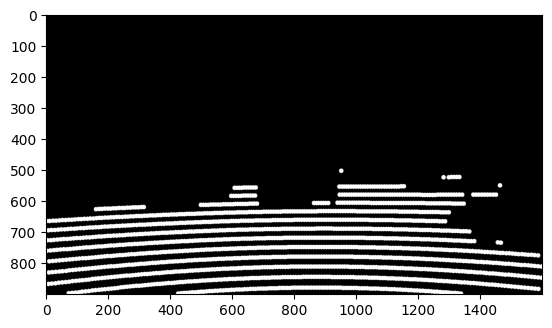

In [95]:
mask_cv = create_morphological_polygon(points, coloring, camera_image_pil.size, 5)
plt.imshow(mask_cv, cmap='gray')

In [91]:
mask_cv.size

(1600, 900)